# Helicity Map
Applies helciity method to data (PI, PA, I, RM) from RM-tools.

Returns current helicity maps.

## Import Data

- Input data is the calculated polarization angles that have be derotated for Faraday Rotation. 
- Angles have been additionally rotated by 90 degrees for magnetic field vectors instead of E-field vectors. 
- Input data is an array with shape (200,200) that has been cut out from the original data
- Data has been masked with an ellipse which zeros all values outside ellipse

In [2]:
import os
os.chdir('/Users/gabriellegalloway/Desktop/astro')
os.getcwd()

'/Users/gabriellegalloway/Desktop/astro'

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
import aplpy 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#DA530
PA = fits.getdata("DA530/phi0.fits")[0,0]
I = fits.getdata("DA530/i10450.fits")[0,0]
PI = fits.getdata("DA530/pi10450.fits")[0,0]
RM = fits.getdata("DA530/rm6-28.fits")[0,0]

In [16]:
print("Max: " + str(np.nanmax(PA)))
print("Min: " + str(np.nanmin(PA)))

Max: 57.27536
Min: -22.155117


In [6]:
# remove 3rd and 4th axes in header
head= fits.getheader("DA530/phi0.fits")
head["NAXIS"]=2
del head["NAXIS3"]
del head["NAXIS4"]
del head["CTYPE3"]
del head["CTYPE4"]
del head["CRVAL3"]
del head["CRVAL4"]
del head["CRPIX3"]
del head["CRPIX4"]
del head["CDELT3"]
del head["CDELT4"]
del head["CROTA3"]
del head["CROTA4"]


## Remove bad pixels

In [27]:
#first use the RM map as a mask (since it’s nan where PI is low) 
mask=np.where(np.isfinite(RM), 1, 0)

#then multiply this mask by PI and divide by I to make a fraction map
frac=(mask*PI)/I

#then remove additional bad fractional pol values
frac[frac>0.7]=np.nan
frac[frac<=0.]=np.nan

mask=np.where(np.isfinite(frac), 1, 0)

#use the mask to remove possible bad values
PA=mask*PA
PI=mask*PI
I=mask*I
RM=mask*RM

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


In [28]:
print("Max: " + str(np.nanmax(PA_new)))
print("Min: " + str(np.nanmin(PA_new)))

Max: 57.275360107421875
Min: -22.15511703491211


##  Implementing model code on data
The model code computes helicity for each pixel by computing a boundary integral of the neighbouring pixels. 

First, $\langle B_z \rangle$ is computed from the rotation measure, i.e. 
$\langle B_z \rangle = \frac{RM}{\langle n_e \rangle k L}$, with $k=0.82\,\rm rad/m^2 $

$L$ is the length of the SNR in parsecs. This is calculated by using the small angle approximation: $ L= \theta A$, where $A=$ distance to SNR in parsecs, and $\theta$ is the angular distance across object in radians. $A$ can be retrieved from http://snrcat.physics.umanitoba.ca/SNRtable.php for different SNRs.

The distance to the center of G93.3 is 2.2 $\pm$ 0.5 kpc (https://iopscience.iop.org/article/10.1086/522299). 

In [57]:
#PARAMETERS
N=512
ne = 1 # Here we will assume ne=1, but typically it's 0.1
k = 0.82 #[rad/m^2]
A = 2200 # distance to SNR [parsecs]
theta = 0.5 #[deg] SNR is approx. rectangular with dimensions [0.4472, 0.5111]
L = theta*np.pi/180*A #width of SNR [parsec]
ngamma = 1 #assumption

In [59]:
# Bz
Bz = 2 * RM / ne / k / (2*L)

$\langle B_x \rangle$ and $\langle B_y \rangle$ can be obtained inverting  synchrotron emission, i.e. derotating $\Psi_{1/2}$ and computing the perpendicular component of the field from the intensity, $I$.

In [60]:
# Bx and By
Bxy = np.sqrt(I / ngamma / (2*L))
Bx = Bxy * np.cos(PA - 90)
By = Bxy * np.sin(PA - 90)

In [61]:
# Eulerian mesh
[x, y] = np.meshgrid( np.linspace(-L,L,N), np.linspace(-L,L,N))

In [62]:
# Jz

#boundary radius excluding central pixel
s = 5 

#e.g. s=1 corresponds to 3x3 pixel regions
#e.g. s=2 corresponds to 5x5 pixel regions

Jz = np.zeros([N,N]);
for i in np.arange(2,N-s,1):
    for j in np.arange(2,N-s,1):
        Jz[i,j] = -sum(Bx[i-s,j-s:j+s]) * ( x[i-s,j-s]-x[i-s,j+s] )
        Jz[i,j] = Jz[i,j] - sum(Bx[i+s,j-s:j+s]) * ( x[i+s,j+s]-x[i+s,j-s] )
        Jz[i,j] = Jz[i,j] - sum(By[i-s:i+s,j-s]) * ( y[i+s,j-s]-y[i-s,j-s] )
        Jz[i,j] = Jz[i,j] - sum(By[i-s:i+s,j+s]) * ( y[i-s,j+s]-y[i+s,j+s] )
        Jz[i,j] = Jz[i,j] / abs(x[i-s,j-s]-x[i-s,j+s]) / abs(y[i+s,j-s]-y[i-s,j-s]) / 3

# THERE MUST BE A FACTOR OF 1/3 IN J, I DON'T KNOW WHY IT SHOULD BE
# HERE, BUT IT SHOULD, BECAUSE WITHOUT IT MY J IS 3 TIMES BIGGER THAN
# REAL [CURL_B]_z

# Z-component of Helicity -ish
Hz = Jz * Bz

In [63]:
filename1= "DA530/Hz_s" + str(s) + ".fits" 
fits.writeto(filename1 , Hz, head, overwrite=True)

Changed DATE-OBS from '2000-01-01                  ' to '2000-01-01T00:00:00.0''. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.122e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.136e-04 [aplpy.core]


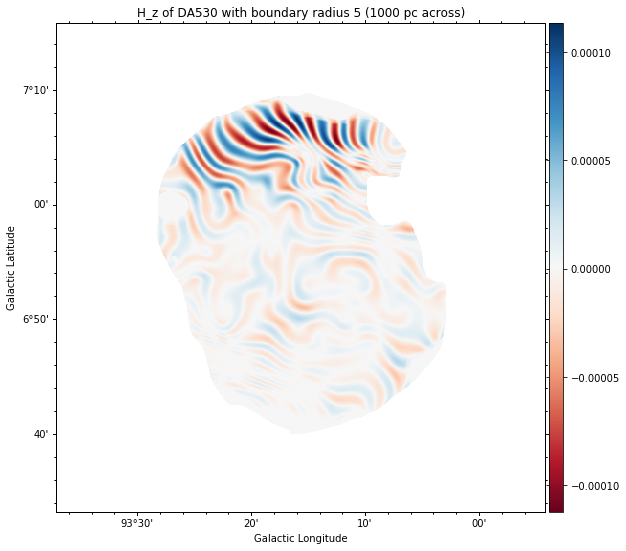

In [67]:
#plot Hz 
f1 = aplpy.FITSFigure(filename1, convention="calabretta")
f1.show_colorscale(cmap="RdBu")
f1.add_colorbar()
fi.add_grid()
#f1.show_regions("DA530_rec.reg")
f1.tick_labels.set_font(size='large')
f1.set_title("H_z of DA530 with boundary radius " + str(s))

filename2= "DA530/Hz_s" + str(s) + ".png"
f1.savefig(filename2, dpi=600)